In [9]:
%config Completer.use_jedi = False
# fixes firefox tab completion

In [10]:
# submodules
import sys
import os

sys.path.append(os.path.abspath('randomness_testsuite'))
sys.path.append(os.path.abspath('spkit'))

In [11]:
sys.path

['/opt/asdf/installs/python/3.11.9/lib/python311.zip',
 '/opt/asdf/installs/python/3.11.9/lib/python3.11',
 '/opt/asdf/installs/python/3.11.9/lib/python3.11/lib-dynload',
 '',
 '/home/q/.jupyter/jupyter/lib/python3.11/site-packages',
 '/home/q/.jupyter/work/qc-classifier-ours/randomness_testsuite',
 '/home/q/.jupyter/work/qc-classifier-ours/spkit',
 '/home/q/.jupyter/work/qc-classifier-ours/randomness_testsuite',
 '/home/q/.jupyter/work/qc-classifier-ours/spkit']

In [12]:
# Importing the required libraries
import numpy as np
import pandas as pd
from math import log2, sqrt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from scipy.fft import fft, ifft
from scipy.special import erfc
import itertools

In [13]:
pd.options.mode.copy_on_write = "warn"

In [14]:
# steve nang's nist sts

from FrequencyTest import FrequencyTest
from RunTest import RunTest
from Matrix import Matrix
from Spectral import SpectralTest
from TemplateMatching import TemplateMatching
from Universal import Universal
from Complexity import ComplexityTest
from Serial import Serial
from ApproximateEntropy import ApproximateEntropy
from CumulativeSum import CumulativeSums
from RandomExcursions import RandomExcursions

# the other randomness tests

# Apply randomness tests
def apply_nist_randomness_tests(df, tests=[], test_functions={}):
    """if not tests:
        raise ValueError("No randomness tests specified.")"""

    test_functions = test_functions | {
        'frequency_test': FrequencyTest.monobit_test,
        'block_frequency_test': FrequencyTest.block_frequency,
        'runs_test': RunTest.run_test,
        # 'longest_one_block_test': RunTest.longest_one_block_test, # 100 chars is too short
        'binary_matrix_rank_test': Matrix.binary_matrix_rank_text, # typo, needs fixing. and need to fix import
        'spectral_test': SpectralTest.spectral_test,
        'non_overlapping_template_matching_test': lambda x: TemplateMatching.non_overlapping_test(x, template_pattern='00000001', block=12), # tuned to speed up a bit
        # 'overlapping_template_matching_test': TemplateMatching.overlapping_patterns, # always gives nan
        # 'maurer_universal_test': Universal.statistical_test, # 100 chars is too short. minimum length to be useful is 387840
        # based on compression ratio. we should use that as a metric
        'linear_complexity_test': ComplexityTest.linear_complexity_test,
        'approximate_entropy_test': ApproximateEntropy.approximate_entropy_test,
        'cumulative_sums_test_forward': lambda x: CumulativeSums.cumulative_sums_test(x, 0),
        'cumulative_sums_test_backward': lambda x: CumulativeSums.cumulative_sums_test(x, 1),

        # these return multiple p-values, will have to split them out later
        # 'serial_test': lambda x: Serial.serial_test(x, pattern_length=8), # slow. tune down the substring length
        # 'random_excursions_test': RandomExcursions.random_excursions_test
        # 'random_excursions_variant_test': RandomExcursions.variant_test
    }
    
    if tests == []:
        tests = test_functions.keys()

    def run_function(x, test):
        res = test_functions[test](x)
        #print(type(res))
        if isinstance(res, tuple):
            return res[0]
        else:
            return res
    for i, test in enumerate(tests):
        if test not in test_functions:
            raise ValueError(f"Invalid randomness test: {test}")
        print(f'Running test {i+1}/{len(tests)}: {test}')
        df[test] = df['bitstring'].apply(lambda x: run_function(x, test)) #test_functions[test](x)) # get the test statistic only

    return df



# Preprocess data
def preprocess_data_nist(df, num_concats, tests, test_functions):
    df = concatenateData(df, num_concats)
    processed_df = apply_nist_randomness_tests(df, tests, test_functions)
    
    # Convert concatenated binary strings into separate columns
    #df_features = pd.DataFrame(processed_df['bitstring'].apply(list).tolist()).astype(int).astype(bool)
    #processed_df = pd.concat([processed_df.drop(columns='bitstring'), df_features], axis=1)

    return processed_df


In [15]:
# compression ratios

import zlib
import lzma
import bz2

# https://stackoverflow.com/questions/31438662/fastest-way-to-measure-compression-ratio-of-a-string-in-python3
def compression_ratio(test_string, library):
    bytes_in = bytes(test_string,'utf-8')
    bytes_out = library.compress(bytes_in)
    lbi = len(bytes_in)
    lbo = len(bytes_out)
    ratio = lbo/lbi
    #message = '%d bytes compressed to %d bytes, ratio %0.3f'%(lbi,lbo,ratio)
    #print(message)
    return ratio

# bitstring = '1' * 100
# print(compression_ratio(bitstring, zlib))
# print(compression_ratio(bitstring, lzma))
# print(compression_ratio(bitstring, bz2))

def zlib_compression_ratio(test_string):
    return compression_ratio(test_string, zlib)

def lzma_compression_ratio(test_string):
    return compression_ratio(test_string, lzma)

def bz2_compression_ratio(test_string):
    return compression_ratio(test_string, bz2)

In [16]:
compress_functions = {
    'zlib_ratio': zlib_compression_ratio,
    'bz2_ratio': bz2_compression_ratio,
    'lzma_ratio': lzma_compression_ratio,
}

In [17]:
#data_df['zlib_ratio'] = data_df['bitstring'].apply(lambda x: zlib_compression_ratio(x))
#data_df['bz2_ratio'] = data_df['bitstring'].apply(lambda x: bz2_compression_ratio(x))
#data_df['lzma_ratio'] = data_df['bitstring'].apply(lambda x: lzma_compression_ratio(x))

In [18]:
import spkit as sp

seq='1'*100
def string_to_array(string):
    return np.array([int(bit) for bit in seq])

def sp_shannon_entropy(bitstring):
    seq = string_to_array(bitstring)
    return sp.entropy(seq)

def sp_collision_entropy(bitstring):
    seq = string_to_array(bitstring)
    return sp.entropy(seq,alpha=2)

"""
# always returns nan
def sp_spectral_entropy_fft(bitstring):
    seq = string_to_array(bitstring)
    return sp.entropy_spectral(seq,fs=2,method='fft') # sample 2 bits at a time

def sp_spectral_entropy_welch(bitstring):
    seq = string_to_array(bitstring)
    return sp.entropy_spectral(seq,fs=2,method='welch') # sample 2 bits at a time
"""

def sp_sample_entropy(bitstring):
    seq = string_to_array(bitstring)
    return sp.entropy_sample(X=seq,m=2,r=0.2)

def sp_svd_entropy(bitstring):
    seq = string_to_array(bitstring)
    return sp.entropy_svd(seq, normalize=True)

for f in [
    sp_shannon_entropy,
          sp_collision_entropy,
    #sp_spectral_entropy_fft,
    #sp_spectral_entropy_welch,
    sp_sample_entropy,
    sp_svd_entropy,
    ]:
    print(f(seq))

-1.4426951603302212e-10
-2.8853903202276337e-10
0.01025650016718911
5.939714095792269e-15


In [19]:
sp_entropy_functions = {
    'sp_shannon_entropy': sp_shannon_entropy,
    'sp_collision_entropy': sp_collision_entropy,
    'sp_sample_entropy': sp_sample_entropy,
    'sp_svd_entropy': sp_svd_entropy
}

In [20]:
# Concatenate data
def concatenateData(df, num_concats):
    if num_concats == 0: # do nothing
        return df #.rename(columns={'binary_number': 'bitstring'})
    new_df = pd.DataFrame({
        'bitstring': [''] * (len(df) // num_concats), 
        'label': [0] * (len(df) // num_concats)
    })

    # Loop through each group of num_concats rows and concatenate their 'binary_number' strings
    for i in range(0, len(df), num_concats):
        new_df.iloc[i // num_concats, 0] = ''.join(df['bitstring'][i:i + num_concats])
        new_df.iloc[i // num_concats, 1] = df['label'][i]

    return new_df

# Calculate Shannon entropy for each concatenated binary sequence
def shannon_entropy(binary_string):
    if len(binary_string) % 2 != 0:
        raise ValueError("Binary string length must be a multiple of 2.")
    
    patterns = ['00', '10', '11', '01']
    frequency = {pattern: 0 for pattern in patterns}
    
    for i in range(0, len(binary_string), 2):
        segment = binary_string[i:i+2]
        if segment in patterns:
            frequency[segment] += 1
    
    total_segments = sum(frequency.values())
    
    entropy = 0
    for count in frequency.values():
        if count > 0:
            probability = count / total_segments
            entropy -= probability * log2(probability)
    
    return entropy


def classic_spectral_test(bit_string):
    bit_array = 2 * np.array([int(bit) for bit in bit_string]) - 1
    dft = fft(bit_array)
    n_half = len(bit_string) // 2 + 1
    mod_dft = np.abs(dft[:n_half])
    threshold = np.sqrt(np.log(1 / 0.05) / len(bit_string))
    peaks_below_threshold = np.sum(mod_dft < threshold)
    expected_peaks = 0.95 * n_half
    d = (peaks_below_threshold - expected_peaks) / np.sqrt(len(bit_string) * 0.95 * 0.05)
    p_value = erfc(np.abs(d) / np.sqrt(2)) / 2
    return d

def frequency_test(bit_string):
    n = len(bit_string)
    count_ones = bit_string.count('1')
    count_zeros = bit_string.count('0')
    
    # The test statistic
    s = (count_ones - count_zeros) / sqrt(n)
    
    # The p-value
    p_value = erfc(abs(s) / sqrt(2))
    
    return p_value

def runs_test(bit_string):
    n = len(bit_string)
    runs = 1  # Start with the first run
    for i in range(1, n):
        if bit_string[i] != bit_string[i - 1]:
            runs += 1
    
    n0 = bit_string.count('0')
    n1 = bit_string.count('1')
    
    # Expected number of runs
    expected_runs = (2 * n0 * n1 / n) + 1
    variance_runs = (2 * n0 * n1 * (2 * n0 * n1 - n)) / (n ** 2 * (n - 1))
    
    # The test statistic
    z = (runs - expected_runs) / sqrt(variance_runs)
    
    # The p-value
    p_value = erfc(abs(z) / sqrt(2))
    
    return p_value

def linear_complexity(bit_string, M=500):
    # Perform linear complexity test with block size M
    n = len(bit_string)
    bit_array = np.array([int(bit) for bit in bit_string])
    lc = 0  # Initialize linear complexity
    
    # Process blocks of size M
    for i in range(0, n, M):
        block = bit_array[i:i+M]
        if len(block) < M:
            continue
        
        lc_block = 0
        for j in range(M):
            if block[j] == 1:
                lc_block = j + 1
        
        lc += lc_block
    
    lc = lc / (n / M)
    return lc

def autocorrelation_test(bit_string, lag=1):
    n = len(bit_string)
    bit_array = np.array([int(bit) for bit in bit_string])
    autocorrelation = np.correlate(bit_array, np.roll(bit_array, lag), mode='valid')[0]
    return autocorrelation / n

def maurer_universal_test(bit_string):
    k = 6
    l = 5
    q = 20
    bit_array = np.array([int(bit) for bit in bit_string])
    max_val = 2**k
    init_subseq = bit_array[:q]
    rest_subseq = bit_array[q:]
    d = {}
    for i in range(len(init_subseq) - k + 1):
        d[tuple(init_subseq[i:i+k])] = i
    t = []
    for i in range(len(rest_subseq) - k + 1):
        subseq = tuple(rest_subseq[i:i+k])
        if subseq in d:
            t.append(i - d[subseq])
            d[subseq] = i
    if not t:
        return 0
    t = np.array(t)
    log_avg = np.mean(np.log2(t))
    return log_avg - np.log2(q)

def binary_matrix_rank_test(bit_string, M=32, Q=32):
    bit_array = np.array([int(bit) for bit in bit_string])
    num_matrices = len(bit_array) // (M * Q)
    ranks = []
    for i in range(num_matrices):
        matrix = bit_array[i*M*Q:(i+1)*M*Q].reshape((M, Q))
        rank = np.linalg.matrix_rank(matrix)
        ranks.append(rank)
    return np.mean(ranks)

def cumulative_sums_test(bit_string):
    bit_array = np.array([int(bit) for bit in bit_string])
    adjusted = 2 * bit_array - 1
    cumulative_sum = np.cumsum(adjusted)
    max_excursion = np.max(np.abs(cumulative_sum))
    return max_excursion

def longest_run_ones_test(bit_string, block_size=100):
    bit_array = np.array([int(bit) for bit in bit_string])
    num_blocks = len(bit_array) // block_size
    max_runs = []
    for i in range(num_blocks):
        block = bit_array[i*block_size:(i+1)*block_size]
        max_run = max([len(list(g)) for k, g in itertools.groupby(block) if k == 1])
        max_runs.append(max_run)
    return np.mean(max_runs)

def random_excursions_test(bit_string):
    bit_array = np.array([int(bit) for bit in bit_string])
    bit_array = 2 * bit_array - 1  # Convert to ±1

    cumulative_sum = np.cumsum(bit_array)
    states = np.unique(cumulative_sum)

    if 0 not in states:
        states = np.append(states, 0)
    state_counts = {state: 0 for state in states}
    for state in cumulative_sum:
        state_counts[state] += 1

    state_counts[0] -= 1  # Adjust for zero state
    pi = [0.5 * (1 - (1 / (2 * state + 1)**2)) for state in states]
    x = np.sum([(state_counts[state] - len(bit_string) * pi[i])**2 / (len(bit_string) * pi[i]) for i, state in enumerate(states)])

    return x


def unique_subsequences(bit_string, length=4):
    bit_array = np.array([int(bit) for bit in bit_string])
    n = len(bit_array)
    subsequences = set()
    
    for i in range(n - length + 1):
        subseq = tuple(bit_array[i:i+length])
        subsequences.add(subseq)
    
    return len(subsequences)

def sample_entropy(bit_string, m=2, r=0.2):
    bit_array = np.array([int(bit) for bit in bit_string])
    N = len(bit_array)
    
    def _phi(m):
        x = np.array([bit_array[i:i+m] for i in range(N - m + 1)])
        C = np.sum(np.all(np.abs(x[:, None] - x) <= r, axis=2), axis=0) / (N - m + 1.0)
        return np.sum(C) / (N - m + 1.0)
    
    return -np.log(_phi(m + 1) / _phi(m))

def permutation_entropy(bit_string, order=3):
    bit_array = np.array([int(bit) for bit in bit_string])
    n = len(bit_array)
    
    permutations = np.array(list(itertools.permutations(range(order))))
    c = np.zeros(len(permutations))
    
    for i in range(n - order + 1):
        sorted_index_array = tuple(np.argsort(bit_array[i:i+order]))
        for j, p in enumerate(permutations):
            if np.array_equal(p, sorted_index_array):
                c[j] += 1
    
    c = c / (n - order + 1)
    pe = -np.sum(c * np.log2(c + np.finfo(float).eps))
    return pe

def lyapunov_exponent(bit_string, m=2, t=1):
    bit_array = np.array([int(bit) for bit in bit_string])
    N = len(bit_array)
    
    def _phi(m):
        x = np.array([bit_array[i:i+m] for i in range(N - m + 1)])
        C = np.sum(np.all(np.abs(x[:, None] - x) <= t, axis=2), axis=0) / (N - m + 1.0)
        return np.sum(np.log(C + np.finfo(float).eps)) / (N - m + 1.0)
    
    return abs(_phi(m) - _phi(m + 1))

def entropy_rate(bit_string, k=2):
    bit_array = np.array([int(bit) for bit in bit_string])
    n = len(bit_array)
    prob = {}
    
    for i in range(n - k + 1):
        subseq = tuple(bit_array[i:i + k])
        if subseq in prob:
            prob[subseq] += 1
        else:
            prob[subseq] = 1
    
    for key in prob:
        prob[key] /= (n - k + 1)
    
    entropy_rate = -sum(p * log2(p) for p in prob.values())
    return entropy_rate


# Calculate min-entropy
def calculate_min_entropy(sequence):
    sequence = np.asarray(sequence, dtype=float)  # Convert sequence to float
    p = np.mean(sequence)  # Proportion of ones
    max_prob = max(p, 1 - p)
    if max_prob == 0:  # Handle the case where all bits are the same
        return 0
    min_entropy = -np.log2(max_prob)
    return min_entropy





In [21]:
# Apply randomness tests
def apply_randomness_tests(df, tests):
    if not tests:
        raise ValueError("No randomness tests specified.")

    test_functions = {
        'autocorrelation': autocorrelation_test,
        'cumulative_sums': cumulative_sums_test,
        'spectral_test': classic_spectral_test,
        'frequency_test': frequency_test,
        'runs_test': runs_test,
        'shannon_entropy': shannon_entropy,
        'min_entropy': calculate_min_entropy,
        'entropy_rate': entropy_rate,
        'lyapunov_exponent': lyapunov_exponent,
        'permutation_entropy': permutation_entropy,
        'sample_entropy': sample_entropy,
        'unique_subsequences': unique_subsequences,
        'random_excursions_test': random_excursions_test,
        'longest_run_ones_test': longest_run_ones_test,
        #'cumulative_sums_test': cumulative_sums_test,
        'binary_matrix_rank_test': binary_matrix_rank_test,
        'maurer_universal_test': maurer_universal_test,
        'linear_complexity': linear_complexity,
    }

    for i, test in enumerate(tests):
        if test not in test_functions:
            raise ValueError(f"Invalid randomness test: {test}")
        print(f'Running test {i+1}/{len(tests)}: {test}')
        df[test] = df['bitstring'].apply(test_functions[test])

    return df

# Preprocess data
def preprocess_data(df, num_concats, tests):
    df = concatenateData(df, num_concats)
    processed_df = apply_randomness_tests(df, tests)
    
    # Convert concatenated binary strings into separate columns
    df_features = pd.DataFrame(processed_df['bitstring'].apply(list).tolist()).astype(int).astype(bool)
    processed_df = pd.concat([processed_df.drop(columns='bitstring'), df_features], axis=1)

    return processed_df


# Main
file_path = 'AI_2qubits_training_data.txt'

# Read the data from the file
data = []
with open(file_path, 'r') as file:
    for line in file:
        if line.strip():
            binary_number, label = line.strip().split()
            data.append((binary_number, int(label)))

# Convert the data into a DataFrame
df = pd.DataFrame(data, columns=['binary_number', 'label'])


In [22]:
data_df = pd.read_csv('AI_2qubits_training_data.txt', delimiter=' ', names=['bitstring', 'label'])

In [23]:
data_df

,bitstring,label
0,0100111111110000000000101110100011011011110000...,1
1,0110011011110001111110001000001110011110011100...,1
2,1110100101110111111101101100110101111101010001...,1
3,1101000011100100011101001110111100011110100111...,1
4,0000000000100101001101100000101000101110110001...,1
...,...,...
13995,1111010111001101111011010000011011100100111100...,4
13996,0101100011000001111011001010001101110100000101...,4
13997,1100111100111101111000001100010010001111111011...,4
13998,1101110000111110011101001100111100001011000010...,4


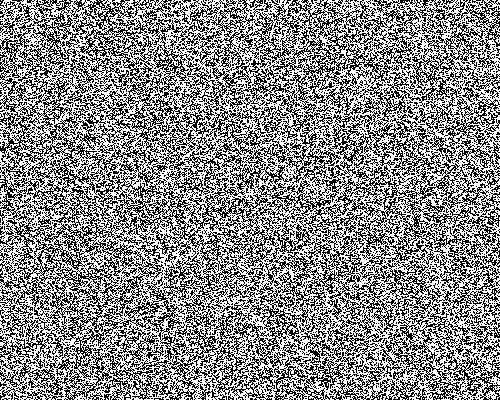

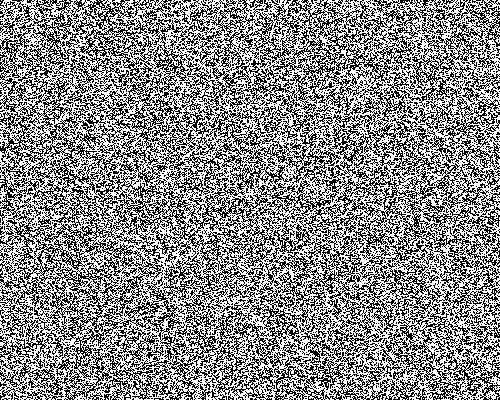

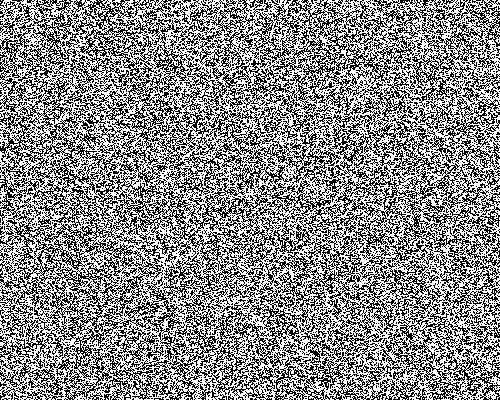

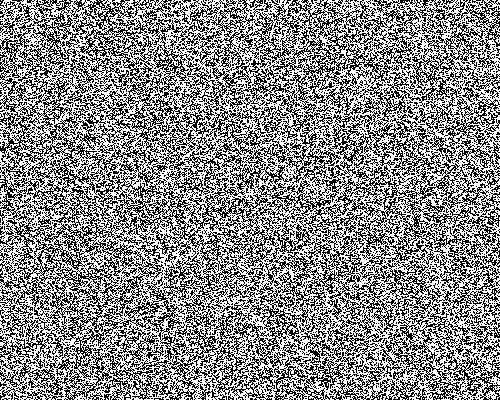

In [24]:
# try to read as an image
# these are not very informative, however, CNNs could classify 10x10 images?
# probably unlikely. again, the PCA is not very informative without a large number of bits
from PIL import Image
for i in range(1,5):
    pixel_array = data_df[data_df.label == 1].bitstring.values
    pixel_array = np.asarray([[int(i) for i in s] for s in pixel_array]).astype('uint8')
    pixel_array = pixel_array.reshape((400,500))
    image = Image.fromarray(pixel_array*255)
    display(image)

In [25]:
def binary_series_to_string(x):
    return ''.join(x['bitstring'].to_list())

# work around deprecation warning
single_string_df = data_df.groupby('label')[['label','bitstring']].apply(binary_series_to_string)
single_string_df = pd.DataFrame(single_string_df, columns=['bitstring'])
single_string_df

,bitstring
label,
1,0100111111110000000000101110100011011011110000...
2,0110011100111011110010111100100101000101101111...
3,1001000011110111101011010100111001000001001100...
4,0011011101000100100001010011110010000001000111...


In [26]:
def window(word, size=1, gap=1):
    for i in range(0, len(word)-size + 1, gap):
        yield word[i:i+size]

def gen_substrings(string):
    return window(string, size=100, gap=2)

In [27]:
def string_into_substrings(string, size=2):
    if len(string) % size != 0:
        1/0 # what to raise?
    return window(string, size=size, gap=size)

list(string_into_substrings('abcdef',size=3))


['abc', 'def']

In [28]:
# factors of 20000, hardcoded
from scipy import stats
factors = [1, 2, 4, 5, 8, 10, 16, 20, 25, 32, 40, 50, 80, 100, 125, 160, 200, 250, 400, 500, 625, 800, 1000, 1250, 2000, 2500, 4000, 5000, 10000, 20000]
from collections import Counter
for f in factors:
    frequencies = []
    for i in range(len(single_string_df)):
        #print(len(single_string_df.iloc[i].bitstring))
        words = list(string_into_substrings(single_string_df.iloc[i].bitstring, size=f))
        counts = np.unique(words, return_counts=True)[1] # take freqs only
        counts = counts / len(words) # normalize
        frequencies.append(counts)

    # check if the frequencies are the same
    #print(f, frequencies)
    #print(f, )
    print(f, {max(x) for x in frequencies}) # prints the number of unique bitstrings observed
        #print(f)
    """    # pairwise ks test
    for i in range(len(frequencies)):
        #for j in range(i):
            #print(i,j)
            d1 = frequencies[i]
            #d2 = frequencies[j]
            print(f, i, j, d1.shape)#, d2.shape)
            #print(d1.shape == d2.shape)
            #p = stats.chisquare(d1, d2).pvalue # chisquare requires 0 entries which are not sparse
            #if p < 0.05:
                #print(f, i, j, p)
    #if f > 4: break"""

1 {0.54676, 0.565125, 0.50439875, 0.508145}
2 {0.32716, 0.35044, 0.33176, 0.2744}
4 {0.10782, 0.1221, 0.10932, 0.07506}
5 {0.0595, 0.0686, 0.05579375, 0.038625}
8 {0.01548, 0.00588, 0.01128, 0.01202}
10 {0.0041375, 0.0019, 0.0043, 0.0054}
16 {0.0003, 0.0004, 0.00032}
20 {0.0002, 0.0003, 0.000125}
25 {0.000125, 6.25e-05, 0.00025}
32 {4e-05, 0.00016}
40 {0.0002, 5e-05}
50 {6.25e-05, 0.00025}
80 {0.0001, 0.0004}
100 {0.000125, 0.0005}
125 {0.000625, 0.00015625}
160 {0.0002, 0.0008}
200 {0.001, 0.00025}
250 {0.00125, 0.0003125}
400 {0.002, 0.0005}
500 {0.0025, 0.000625}
625 {0.003125, 0.00078125}
800 {0.004, 0.001}
1000 {0.00125, 0.005}
1250 {0.00625, 0.0015625}
2000 {0.0025, 0.01}
2500 {0.0125, 0.003125}
4000 {0.02, 0.005}
5000 {0.025, 0.00625}
10000 {0.05, 0.0125}
20000 {0.1, 0.025}


sliding window for more training data

In [29]:
len_20_substrings = data_df.groupby('label').apply(lambda x: ''.join(x['bitstring'].to_list()))

#def window(word, size=1, gap=1): return [word[i:i+size] for i in range(0, len(word)-size + 1, gap)]

for i in range(len(len_20_substrings)):
    len_20_substrings.iloc[i] = list(string_into_substrings(len_20_substrings.iloc[i], size=20))  # sample 2 qubits at a time

# TODO: assume bits are processed in a single stream - k-fold cross validation should split into k chunks ahead of time to preserve time dependency information?
len_20_substrings = pd.DataFrame(len_20_substrings.explode(), columns=['bitstring']).reset_index()

/tmp/ipykernel_27521/3315578408.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [30]:
len_20_substrings

,label,bitstring
0,1,01001111111100000000
1,1,00101110100011011011
2,1,11000011010100100111
3,1,11010001100111110111
4,1,00111010001111110010
...,...,...
69995,4,00111101000010000011
69996,4,11000000001100111011
69997,4,00000100100011001100
69998,4,00001010101100000001


In [31]:
windowed_bitstring_df = data_df.groupby('label').apply(lambda x: ''.join(x['bitstring'].to_list()))

#def window(word, size=1, gap=1): return [word[i:i+size] for i in range(0, len(word)-size + 1, gap)]

for i in range(len(windowed_bitstring_df)):
    windowed_bitstring_df.iloc[i] = list(window(windowed_bitstring_df.iloc[i], 100, 2))  # sample 2 qubits at a time

# TODO: assume bits are processed in a single stream - k-fold cross validation should split into k chunks ahead of time to preserve time dependency information?
windowed_bitstring_df = pd.DataFrame(windowed_bitstring_df.explode(), columns=['bitstring']).reset_index()

/tmp/ipykernel_27521/1899360156.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [32]:
windowed_bitstring_df

,label,bitstring
0,1,0100111111110000000000101110100011011011110000...
1,1,0011111111000000000010111010001101101111000011...
2,1,1111111100000000001011101000110110111100001101...
3,1,1111110000000000101110100011011011110000110101...
4,1,1111000000000010111010001101101111000011010100...
...,...,...
699799,4,0011010000111101000010000011110000000011001110...
699800,4,1101000011110100001000001111000000001100111011...
699801,4,0100001111010000100000111100000000110011101100...
699802,4,0000111101000010000011110000000011001110110000...


## Exploratory data analysis

do any of the bitstrings overlap with each other?


In [33]:
unique_bitstrings_series = single_string_df.groupby('label').apply(lambda x: set(x['bitstring']))
for i in range(1,5):
    for j in range(i, 5):
        if i == j: continue
        print(f"Overlapping bitstrings between QC {i},{j}")
        print(len(unique_bitstrings_series[i] & unique_bitstrings_series[j]))

Overlapping bitstrings between QC 1,2
0
Overlapping bitstrings between QC 1,3
0
Overlapping bitstrings between QC 1,4
0
Overlapping bitstrings between QC 2,3
0
Overlapping bitstrings between QC 2,4
0
Overlapping bitstrings between QC 3,4
0


In [34]:
unique_bitstrings_series = windowed_bitstring_df.groupby('label').apply(lambda x: set(x['bitstring']))
for i in range(1,5):
    for j in range(i, 5):
        if i == j: continue
        print(f"Overlapping bitstrings between QC {i},{j}")
        print(len(unique_bitstrings_series[i] & unique_bitstrings_series[j]))

Overlapping bitstrings between QC 1,2
0
Overlapping bitstrings between QC 1,3
0
Overlapping bitstrings between QC 1,4
0
Overlapping bitstrings between QC 2,3
0
Overlapping bitstrings between QC 2,4
0
Overlapping bitstrings between QC 3,4
0


/tmp/ipykernel_27521/3168787411.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [35]:
unique_bitstrings_series = len_20_substrings.groupby('label').apply(lambda x: set(x['bitstring']))
for i in range(1,5):
    for j in range(i, 5):
        if i == j: continue
        print(f"Overlapping bitstrings between QC {i},{j}")
        print(len(unique_bitstrings_series[i] & unique_bitstrings_series[j]))

Overlapping bitstrings between QC 1,2
146
Overlapping bitstrings between QC 1,3
90
Overlapping bitstrings between QC 1,4
548
Overlapping bitstrings between QC 2,3
91
Overlapping bitstrings between QC 2,4
623
Overlapping bitstrings between QC 3,4
416


/tmp/ipykernel_27521/210303664.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


No overlapping bitstrings in both solutions. Should be possible to get a good solution.

How many data points do we have for each label?

In [36]:
data_df_counts = data_df['label'].value_counts()
data_df_counts

label
4    8000
1    2000
2    2000
3    2000
Name: count, dtype: int64

In [37]:
windowed_bitstring_counts = windowed_bitstring_df['label'].value_counts()
windowed_bitstring_counts

label
4    399951
1     99951
2     99951
3     99951
Name: count, dtype: int64

In [38]:
vc = len_20_substrings.value_counts()
vc[vc>1].sort_index()

label  bitstring           
1      00000111000101101011    2
       00001100011100010010    2
       00010000111011110111    2
       00011000100001010101    2
       00011001010101100111    2
                              ..
4      11111111110001111111    3
       11111111111100011111    2
       11111111111101001000    2
       11111111111101110111    2
       11111111111111100000    2
Name: count, Length: 1943, dtype: int64

Unbalanced data problem. If the model always predicts the majority class, what is the accuracy?

In [39]:
max(data_df_counts) / sum(data_df_counts)

0.5714285714285714

In [40]:
max(windowed_bitstring_counts) / sum(windowed_bitstring_counts)

0.5715185966356294

Imbalanced classes. class_weight='balanced' arg seems to hurt overall accuracy but help the smaller class accuracy.

## Resuming code: let's compute features.

In [41]:
# can you even tell different python rngs apart from each other?

from numpy.random import Generator, PCG64, MT19937, Philox, SFC64, default_rng

classical_random_bits = []
for i, g in enumerate([PCG64, MT19937, Philox, SFC64]):
    rng = Generator(g(seed=42))
    # draw 200000 random bits uniformly, like the bell generator
    rand_bits = rng.integers(2, size=200000)
    # model decoherence (bit flip is just more randomness)
    #idx = np.random.choice(200000,2000*(i*5),replace=False)
    #rand_bits[idx] = 0 # np.logical_not(rand_bits[idx])
    classical_random_bits.append(''.join(str(i) for i in rand_bits))

classical_rng_data = pd.DataFrame(classical_random_bits, columns=['bitstring'])#, index=['label'])
classical_rng_data['label'] = [0,1,2,3]
classical_rng_data.set_index('label')

classical_rng_data = classical_rng_data.groupby('label').apply(lambda x: ''.join(x['bitstring'].to_list()))

#def window(word, size=1, gap=1): return [word[i:i+size] for i in range(0, len(word)-size + 1, gap)]

for i in range(len(classical_rng_data)):
    classical_rng_data.iloc[i] = list(string_into_substrings(classical_rng_data.iloc[i], size=100))  # sample 2 qubits at a time

# TODO: assume bits are processed in a single stream - k-fold cross validation should split into k chunks ahead of time to preserve time dependency information?
classical_rng_data = pd.DataFrame(classical_rng_data.explode(), columns=['bitstring']).reset_index()
classical_rng_data

/tmp/ipykernel_27521/2328623740.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


,label,bitstring
0,0,0110010100111111101010011101100001101101011001...
1,0,1010111101011011000001101101111101101000100011...
2,0,0101001101011010000100101011100101011001010110...
3,0,0101100100110001111100111000011001011001101110...
4,0,1101010010000001100111110011010110001100100011...
...,...,...
7995,3,1000011000000101100110001101010001000111110100...
7996,3,1001111100011000001110101111100111110000000101...
7997,3,1111100001001011001001110011011000000111011000...
7998,3,1101101110111001100111011100001011010111101000...


In [42]:
classical_rng_data['label'] = 5 # lazy
data_df = pd.concat([data_df, classical_rng_data.head(2000)])
data_df

,bitstring,label
0,0100111111110000000000101110100011011011110000...,1
1,0110011011110001111110001000001110011110011100...,1
2,1110100101110111111101101100110101111101010001...,1
3,1101000011100100011101001110111100011110100111...,1
4,0000000000100101001101100000101000101110110001...,1
...,...,...
1995,1111110110100000010010001101011111110001010110...,5
1996,0110001111001100111110001111011111101010001001...,5
1997,1101100100100011100010000000110110111000001000...,5
1998,1001000001011100101110111111101000110101001100...,5


In [43]:
ALL_TESTS = [
            #'autocorrelation',
             'cumulative_sums',
             'spectral_test',
             'frequency_test',
             'runs_test',
             #'shannon_entropy',
             #'min_entropy',
             #'entropy_rate',
             #'lyapunov_exponent',
             #'permutation_entropy',
             #'sample_entropy',
             #'unique_subsequences',
             'random_excursions_test',
             'longest_run_ones_test',
             #'cumulative_sums_test',
             'binary_matrix_rank_test',
             'maurer_universal_test',
             #'linear_complexity',
            ]
def get_features(data_df):
    tests_to_apply = ALL_TESTS # ['spectral_test', 'shannon_entropy', 'frequency_test', 'runs_test', 'autocorrelation']

    # Preprocess data and apply randomness tests
    preprocessed_df = preprocess_data(data_df, num_concats=40, tests=tests_to_apply)
    #preprocessed_df[preprocessed_df.select_dtypes(np.float64).columns] = preprocessed_df.select_dtypes(np.float64).astype(np.float32)
    return preprocessed_df

preprocessed_df = get_features(data_df)
preprocessed_df

In [44]:
def get_nist_features(data_df):
    #tests_to_apply = ALL_TESTS # ['spectral_test', 'shannon_entropy', 'frequency_test', 'runs_test', 'autocorrelation']
    

    # Preprocess data and apply randomness tests
    preprocessed_df = preprocess_data_nist(data_df, num_concats=0, tests=[], test_functions = compress_functions | sp_entropy_functions)
    #preprocessed_df[preprocessed_df.select_dtypes(np.float64).columns] = preprocessed_df.select_dtypes(np.float64).astype(np.float32)
    return preprocessed_df
preprocessed_nist_df = get_nist_features(data_df)
preprocessed_nist_df

Running test 1/17: zlib_ratio
Running test 2/17: bz2_ratio
Running test 3/17: lzma_ratio
Running test 4/17: sp_shannon_entropy
Running test 5/17: sp_collision_entropy
Running test 6/17: sp_sample_entropy
Running test 7/17: sp_svd_entropy
Running test 8/17: frequency_test
Running test 9/17: block_frequency_test
Running test 10/17: runs_test
Running test 11/17: binary_matrix_rank_test
Running test 12/17: spectral_test
Running test 13/17: non_overlapping_template_matching_test
Running test 14/17: linear_complexity_test
Running test 15/17: approximate_entropy_test
Running test 16/17: cumulative_sums_test_forward
Running test 17/17: cumulative_sums_test_backward


,bitstring,label,zlib_ratio,bz2_ratio,lzma_ratio,sp_shannon_entropy,sp_collision_entropy,sp_sample_entropy,sp_svd_entropy,frequency_test,block_frequency_test,runs_test,binary_matrix_rank_test,spectral_test,non_overlapping_template_matching_test,linear_complexity_test,approximate_entropy_test,cumulative_sums_test_forward,cumulative_sums_test_backward
0,0100111111110000000000101110100011011011110000...,1,0.44,0.65,0.96,-1.442695e-10,-2.885390e-10,0.010257,5.939714e-15,0.423711,0.423711,0.178753,-1.0,0.168669,1.0,-1.0,1.0,0.629223,0.459642
1,0110011011110001111110001000001110011110011100...,1,0.45,0.64,0.96,-1.442695e-10,-2.885390e-10,0.010257,5.939714e-15,0.841481,0.841481,0.045847,-1.0,0.646355,1.0,-1.0,1.0,0.814758,0.958638
2,1110100101110111111101101100110101111101010001...,1,0.45,0.64,0.96,-1.442695e-10,-2.885390e-10,0.010257,5.939714e-15,0.109599,0.109599,0.379678,-1.0,0.646355,1.0,-1.0,1.0,0.071458,0.219194
3,1101000011100100011101001110111100011110100111...,1,0.43,0.63,0.96,-1.442695e-10,-2.885390e-10,0.010257,5.939714e-15,0.071861,0.071861,0.775459,-1.0,0.646355,1.0,-1.0,1.0,0.143721,0.071458
4,0000000000100101001101100000101000101110110001...,1,0.41,0.62,0.96,-1.442695e-10,-2.885390e-10,0.010257,5.939714e-15,0.230139,0.230139,0.580984,-1.0,0.646355,1.0,-1.0,1.0,0.143721,0.459642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1111110110100000010010001101011111110001010110...,5,0.42,0.63,0.96,-1.442695e-10,-2.885390e-10,0.010257,5.939714e-15,0.841481,0.841481,0.551016,-1.0,0.168669,1.0,-1.0,1.0,0.540731,0.387010
1996,0110001111001100111110001111011111101010001001...,5,0.44,0.63,0.96,-1.442695e-10,-2.885390e-10,0.010257,5.939714e-15,0.071861,0.071861,0.083252,-1.0,0.646355,1.0,-1.0,1.0,0.042896,0.091001
1997,1101100100100011100010000000110110111000001000...,5,0.43,0.63,0.96,-1.442695e-10,-2.885390e-10,0.010257,5.939714e-15,0.045500,0.045500,0.531971,-1.0,0.646355,1.0,-1.0,1.0,0.055614,0.042896
1998,1001000001011100101110111111101000110101001100...,5,0.43,0.61,0.96,-1.442695e-10,-2.885390e-10,0.010257,5.939714e-15,0.423711,0.423711,0.060654,-1.0,0.168669,1.0,-1.0,1.0,0.814758,0.387010


In [45]:
preprocessed_df = data_df # preprocessed_nist_df

Math errors may cause NAs

In [46]:
any(preprocessed_df.isna())

True

In [47]:
sums = preprocessed_df.isna().sum()
sums[sums>1]


Series([], dtype: int64)

In [48]:
preprocessed_df = preprocessed_df.dropna(axis=1)
preprocessed_df

,bitstring,label,zlib_ratio,bz2_ratio,lzma_ratio,sp_shannon_entropy,sp_collision_entropy,sp_sample_entropy,sp_svd_entropy,frequency_test,block_frequency_test,runs_test,binary_matrix_rank_test,spectral_test,non_overlapping_template_matching_test,linear_complexity_test,approximate_entropy_test,cumulative_sums_test_forward,cumulative_sums_test_backward
0,0100111111110000000000101110100011011011110000...,1,0.44,0.65,0.96,-1.442695e-10,-2.885390e-10,0.010257,5.939714e-15,0.423711,0.423711,0.178753,-1.0,0.168669,1.0,-1.0,1.0,0.629223,0.459642
1,0110011011110001111110001000001110011110011100...,1,0.45,0.64,0.96,-1.442695e-10,-2.885390e-10,0.010257,5.939714e-15,0.841481,0.841481,0.045847,-1.0,0.646355,1.0,-1.0,1.0,0.814758,0.958638
2,1110100101110111111101101100110101111101010001...,1,0.45,0.64,0.96,-1.442695e-10,-2.885390e-10,0.010257,5.939714e-15,0.109599,0.109599,0.379678,-1.0,0.646355,1.0,-1.0,1.0,0.071458,0.219194
3,1101000011100100011101001110111100011110100111...,1,0.43,0.63,0.96,-1.442695e-10,-2.885390e-10,0.010257,5.939714e-15,0.071861,0.071861,0.775459,-1.0,0.646355,1.0,-1.0,1.0,0.143721,0.071458
4,0000000000100101001101100000101000101110110001...,1,0.41,0.62,0.96,-1.442695e-10,-2.885390e-10,0.010257,5.939714e-15,0.230139,0.230139,0.580984,-1.0,0.646355,1.0,-1.0,1.0,0.143721,0.459642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1111110110100000010010001101011111110001010110...,5,0.42,0.63,0.96,-1.442695e-10,-2.885390e-10,0.010257,5.939714e-15,0.841481,0.841481,0.551016,-1.0,0.168669,1.0,-1.0,1.0,0.540731,0.387010
1996,0110001111001100111110001111011111101010001001...,5,0.44,0.63,0.96,-1.442695e-10,-2.885390e-10,0.010257,5.939714e-15,0.071861,0.071861,0.083252,-1.0,0.646355,1.0,-1.0,1.0,0.042896,0.091001
1997,1101100100100011100010000000110110111000001000...,5,0.43,0.63,0.96,-1.442695e-10,-2.885390e-10,0.010257,5.939714e-15,0.045500,0.045500,0.531971,-1.0,0.646355,1.0,-1.0,1.0,0.055614,0.042896
1998,1001000001011100101110111111101000110101001100...,5,0.43,0.61,0.96,-1.442695e-10,-2.885390e-10,0.010257,5.939714e-15,0.423711,0.423711,0.060654,-1.0,0.168669,1.0,-1.0,1.0,0.814758,0.387010


In [49]:
# remove columns with identical features
uniques_df = preprocessed_df.apply(lambda x: len(set(x)))
preprocessed_df = preprocessed_df.drop(columns=uniques_df[uniques_df==1].index)

In [50]:
preprocessed_df = preprocessed_df.rename(columns={i: str(i) for i in range(400)})

In [51]:
preprocessed_df

,bitstring,label,zlib_ratio,bz2_ratio,lzma_ratio,frequency_test,block_frequency_test,runs_test,spectral_test,non_overlapping_template_matching_test,cumulative_sums_test_forward,cumulative_sums_test_backward
0,0100111111110000000000101110100011011011110000...,1,0.44,0.65,0.96,0.423711,0.423711,0.178753,0.168669,1.0,0.629223,0.459642
1,0110011011110001111110001000001110011110011100...,1,0.45,0.64,0.96,0.841481,0.841481,0.045847,0.646355,1.0,0.814758,0.958638
2,1110100101110111111101101100110101111101010001...,1,0.45,0.64,0.96,0.109599,0.109599,0.379678,0.646355,1.0,0.071458,0.219194
3,1101000011100100011101001110111100011110100111...,1,0.43,0.63,0.96,0.071861,0.071861,0.775459,0.646355,1.0,0.143721,0.071458
4,0000000000100101001101100000101000101110110001...,1,0.41,0.62,0.96,0.230139,0.230139,0.580984,0.646355,1.0,0.143721,0.459642
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1111110110100000010010001101011111110001010110...,5,0.42,0.63,0.96,0.841481,0.841481,0.551016,0.168669,1.0,0.540731,0.387010
1996,0110001111001100111110001111011111101010001001...,5,0.44,0.63,0.96,0.071861,0.071861,0.083252,0.646355,1.0,0.042896,0.091001
1997,1101100100100011100010000000110110111000001000...,5,0.43,0.63,0.96,0.045500,0.045500,0.531971,0.646355,1.0,0.055614,0.042896
1998,1001000001011100101110111111101000110101001100...,5,0.43,0.61,0.96,0.423711,0.423711,0.060654,0.168669,1.0,0.814758,0.387010


In [52]:
# attach the bitstrings here, after preprocessing

In [53]:
preprocessed_df.columns

Index(['bitstring', 'label', 'zlib_ratio', 'bz2_ratio', 'lzma_ratio',
       'frequency_test', 'block_frequency_test', 'runs_test', 'spectral_test',
       'non_overlapping_template_matching_test',
       'cumulative_sums_test_forward', 'cumulative_sums_test_backward'],
      dtype='object')

In [54]:
preprocessed_df = preprocessed_df.reset_index().drop(columns=['index'])

In [55]:
df_features = pd.DataFrame(preprocessed_df['bitstring'].apply(list).tolist()).astype(int).astype(bool)
preprocessed_df = pd.concat([preprocessed_df.drop(columns='bitstring'), df_features], axis=1)

In [56]:
preprocessed_df = preprocessed_df.rename(columns={i: str(i) for i in range(4000)})

Train/test splits should not be shuffled since the order that the bits were sampled matters. However, we need to take splits from each of the quantum computers, so the splits really should be interleaved. 

Later we'll use k-fold CV to get a better result.

1. Do you need the bitstrings as features?
- yes. they're important as noise
2. Imbalanced classes?
- yes, but not really relevant it seems
3. More features? (More statistical tests)
- even if we add more, the biggest issue is having enough bits. It's hard to extract meaningful information without having a long enough sequence. Even after adding more training data, eg through sliding windows.

In [59]:
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours

In [62]:
def make_data_splits(preprocessed_df, include_bits=True):
    drop = ['label']
    # need to include bits to prevent model from predicting everything as qc #4
    if not include_bits:
        drop += list(str(i) for i in range(100))
    # Split the data into features (X) and labels (y)
    X = preprocessed_df.drop(columns=drop)#.values
    y = preprocessed_df['label']#.values.astype(int)
    
    jobs=2

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    smote = SMOTE(random_state=42, n_jobs=jobs,)# smote=SMOTE(n_jobs=jobs), enn=EditedNearestNeighbours(n_jobs=jobs, sampling_strategy='all', n_neighbors=5))
    #X_train, y_train = smote.fit_resample(X_train, y_train)
    # Calculate min-entropy for each sequence in the training and testing datasets
    # min-entropy also takes into account the bitstring! is this ok?
    #min_entropy_train = np.apply_along_axis(calculate_min_entropy, 1, X_train)
    #min_entropy_test = np.apply_along_axis(calculate_min_entropy, 1, X_test)

    # Add min-entropy as a feature
    #X_train = np.column_stack((X_train, min_entropy_train))
    #X_test = np.column_stack((X_test, min_entropy_test))

    return X_train, X_test, y_train, y_test

In [63]:
X_train, X_test, y_train, y_test = make_data_splits(preprocessed_df)#, include_bits=False)
X_train, X_test, y_train, y_test

(       zlib_ratio  bz2_ratio  lzma_ratio  frequency_test  \
 676          0.46       0.64        1.00        0.689157   
 12113        0.42       0.65        0.96        1.000000   
 7077         0.47       0.65        1.00        0.841481   
 13005        0.43       0.65        0.96        0.230139   
 12123        0.42       0.64        0.92        0.689157   
 ...           ...        ...         ...             ...   
 13418        0.43       0.63        0.92        0.841481   
 5390         0.45       0.63        0.96        0.317311   
 860          0.47       0.64        0.96        0.841481   
 15795        0.43       0.62        0.96        0.423711   
 7270         0.44       0.63        0.96        0.689157   
 
        block_frequency_test  runs_test  spectral_test  \
 676                0.689157   0.537243       0.021781   
 12113              1.000000   1.000000       0.168669   
 7077               0.841481   0.425847       0.646355   
 13005              0.230139   0.1

Scale all input data. Fit it on the training data only to prevent leakage. Only scale the nonbinary columns.

Mean normalization on test data. A bit sloppy due to binary columns, but it's ok bc they're binary.

In [64]:
X_means = X_train.apply(lambda x: x.mean())
X_stds = X_train.apply(lambda x: x.std())

In [65]:
X_train_normalized = X_train.apply(lambda x: x if x.dtype == bool else (x - X_means[x.name]) / X_stds[x.name])
X_test_normalized = X_test.apply(lambda x: x if x.dtype == bool else (x - X_means[x.name]) / X_stds[x.name])

In [66]:
X_train_normalized, X_test_normalized

(       zlib_ratio  bz2_ratio  lzma_ratio  frequency_test  \
 676      1.424614   0.406989    2.344728        0.821467   
 12113   -0.679775   1.070023    0.314248        1.840765   
 7077     1.950711   1.070023    2.344728        1.320958   
 13005   -0.153678   1.070023    0.314248       -0.683713   
 12123   -0.679775   0.406989   -1.716231        0.821467   
 ...           ...        ...         ...             ...   
 13418   -0.153678  -0.256045   -1.716231        1.320958   
 5390     0.898516  -0.256045    0.314248       -0.397867   
 860      1.950711   0.406989    0.314248        1.320958   
 15795   -0.153678  -0.919079    0.314248       -0.048966   
 7270     0.372419  -0.256045    0.314248        0.821467   
 
        block_frequency_test  runs_test  spectral_test  \
 676                0.821467   0.482901      -1.750879   
 12113              1.840765   1.984429      -1.159130   
 7077               1.320958   0.121448       0.765278   
 13005             -0.683713  -0.8

In [67]:
X_maxes = X_train.apply(lambda x: max(x))
X_mins = X_train.apply(lambda x: min(x))

In [68]:
X_train_zero_one = X_train.apply(lambda x: x if x.dtype == bool else (x - X_mins[x.name]) / (X_maxes[x.name] - X_mins[x.name]))
X_test_zero_one = X_test.apply(lambda x: x if x.dtype == bool else (x - X_mins[x.name]) / (X_maxes[x.name] - X_mins[x.name]))

In [69]:
X_train_zero_one, X_test_zero_one

(       zlib_ratio  bz2_ratio  lzma_ratio  frequency_test  \
 676      0.846154     0.7500    1.000000        0.689156   
 12113    0.538462     0.8125    0.666667        1.000000   
 7077     0.923077     0.8125    1.000000        0.841480   
 13005    0.615385     0.8125    0.666667        0.230138   
 12123    0.538462     0.7500    0.333333        0.689156   
 ...           ...        ...         ...             ...   
 13418    0.615385     0.6875    0.333333        0.841480   
 5390     0.769231     0.6875    0.666667        0.317309   
 860      0.923077     0.7500    0.666667        0.841480   
 15795    0.615385     0.6250    0.666667        0.423710   
 7270     0.692308     0.6875    0.666667        0.689156   
 
        block_frequency_test  runs_test  spectral_test  \
 676                0.689156   0.537243       0.033645   
 12113              1.000000   1.000000       0.260912   
 7077               0.841480   0.425847       1.000000   
 13005              0.230138   0.1

from sklearn.feature_selection import SelectKBest, SelectPercentile
selector = SelectPercentile(k='all').fit(X_train,y_train)
print(selector.get_feature_names_out())
X_train = selector.transform(X_train)
X_test = selector.transform(X_test)
X_train, X_test

In [70]:
import matplotlib.pyplot as plt

With this much data, we need multithreading. Get number of cores now.

In [71]:
import joblib

N_CORES = joblib.cpu_count(only_physical_cores=True)
print(f"Number of physical cores: {N_CORES}")

jobs = N_CORES // 2
print(f"Using {jobs} jobs")

Number of physical cores: 2
Using 1 jobs


Use PCA, TSNE, and UMAP to see the separability of data points, which suggests a potential to classify them. With enough samples, trying to distinguish the computers is possible with the bitstrings alone.

[0.01733602 0.01315174]


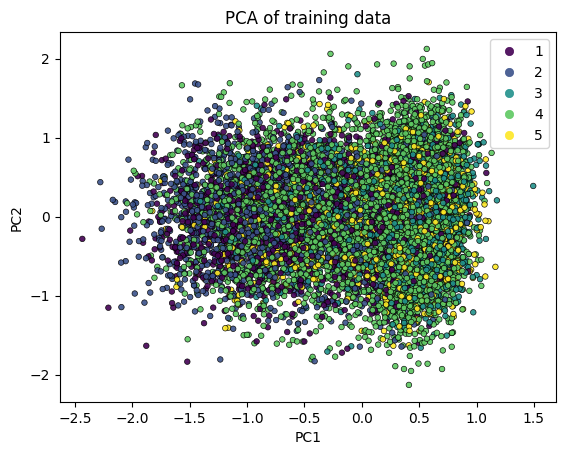

In [72]:
# all data
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(X_train)#) [[str(i) for i in range(20)]]) #X_train[[str(i) for i in range(4000)]])
#display(reduced_data.shape)
#display(preprocessed_df.index.shape)
print(pca.explained_variance_ratio_)
#print(pca.singular_values_)
fig, ax = plt.subplots()
scatter = plt.scatter(reduced_data[:,0], reduced_data[:,1], c=y_train, cmap='viridis',alpha=0.9,edgecolors='black',linewidths=0.5, s=16)
ax.set(xlabel='PC1', ylabel='PC2')
ax.legend(scatter.legend_elements()[0],set(y_train))
ax.set_title('PCA of training data')
plt.show()
plt.close()

[0.01476657 0.01345928]


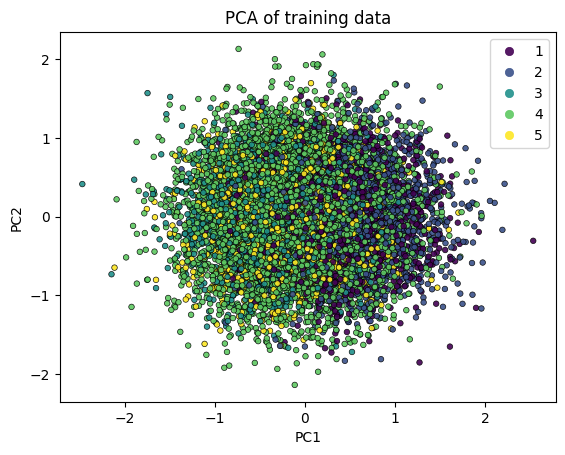

In [73]:
# bits only are not very informative
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(X_train[[str(i) for i in range(100)]])
#display(reduced_data.shape)
#display(preprocessed_df.index.shape)
print(pca.explained_variance_ratio_)
#print(pca.singular_values_)
fig, ax = plt.subplots()
scatter = plt.scatter(reduced_data[:,0], reduced_data[:,1], c=y_train, cmap='viridis',alpha=0.9,edgecolors='black',linewidths=0.5, s=16)
ax.set(xlabel='PC1', ylabel='PC2')
ax.legend(scatter.legend_elements()[0],set(y_train))
ax.set_title('PCA of training data')
plt.show()
plt.close()

[0.54480575 0.16519035]


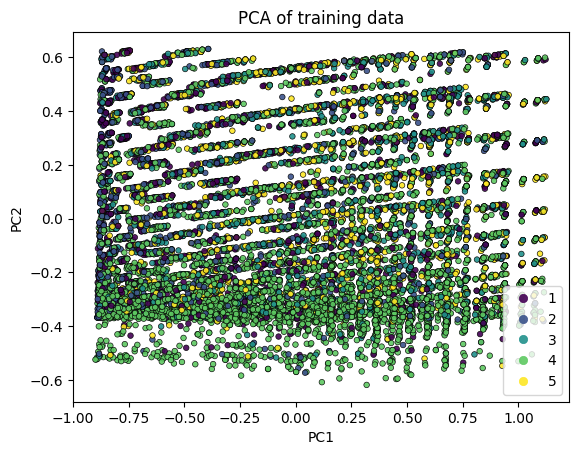

In [109]:
# computed values are somewhat informative
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
to_drop = np.intersect1d([str(i) for i in range(4000)], X_train.columns)
reduced_data = pca.fit_transform(X_train.drop(columns=to_drop))
#display(reduced_data.shape)
#display(preprocessed_df.index.shape)
print(pca.explained_variance_ratio_)
#print(pca.singular_values_)
fig, ax = plt.subplots()
scatter = plt.scatter(reduced_data[:,0], reduced_data[:,1], c=y_train, cmap='viridis',alpha=0.9,edgecolors='black',linewidths=0.5, s=16)
ax.set(xlabel='PC1', ylabel='PC2')
ax.legend(scatter.legend_elements()[0],set(y_train))
ax.set_title('PCA of training data')
plt.show()
plt.close()

TSNE and UMAP probably wont show much difference

%%time
#from sklearn.manifold import TSNE
#tsne = TSNE(n_components=2, perplexity=500, n_jobs=jobs, random_state=42, verbose=1)
from openTSNE.sklearn import TSNE
tsne = TSNE(n_components=2, perplexity=100, n_jobs=jobs, random_state=42)#, verbose=True)
#tsne.fit(X_train.drop(columns=[str(i) for i in range(100)]).values)
reduced_data = tsne.fit_transform(X_train[[str(i) for i in range(4000)]]) # .drop(columns=[str(i) for i in range(4000)]).values)
#display(reduced_data.shape)
#display(preprocessed_df.index.shape)
#print(pca.explained_variance_ratio_)
#print(pca.singular_values_)
fig, ax = plt.subplots()
scatter = plt.scatter(reduced_data[:,0], reduced_data[:,1], c=y_train, cmap='viridis',alpha=0.9,edgecolors='black',linewidths=0.5, s=16)
ax.set(xlabel='TSNE-1', ylabel='TSNE-2')
ax.legend(scatter.legend_elements()[0],set(y_train))
ax.set_title('TSNE of training data')
plt.show()
plt.close()

# takes forever
%%time
from sklearn.manifold import TSNE as skTSNE
tsne = skTSNE(n_components=2, perplexity=500, n_jobs=jobs, random_state=42)#, verbose=1)
#tsne.fit(X_train.drop(columns=[str(i) for i in range(100)]).values)
#reduced_data = tsne.transform(X_train.drop(columns=[str(i) for i in range(100)]).values)
reduced_data = tsne.fit_transform(X_train.drop(columns=[str(i) for i in range(100)]).values)
#display(reduced_data.shape)
#display(preprocessed_df.index.shape)
#print(pca.explained_variance_ratio_)
#print(pca.singular_values_)
fig, ax = plt.subplots()
scatter = plt.scatter(reduced_data[:,0], reduced_data[:,1], c=y_train, cmap='viridis',alpha=0.9,edgecolors='black',linewidths=0.5, s=16)
ax.set(xlabel='TSNE-1', ylabel='TSNE-2')
ax.legend(scatter.legend_elements()[0],set(y_train))
ax.set_title('TSNE of training data')
plt.show()
plt.close()

%%time
from umap import UMAP
umapper = UMAP(n_jobs=jobs, random_state=42)
reduced_data = umapper.fit_transform(X_train[[str(i) for i in range(4000)]]) #.drop(columns=[str(i) for i in range(4000)]).values)
fig, ax = plt.subplots()
scatter = plt.scatter(reduced_data[:,0], reduced_data[:,1], c=y_train, cmap='viridis',alpha=0.9,edgecolors='black',linewidths=0.5, s=16)
ax.set(xlabel='UMAP-1', ylabel='UMAP-2')
ax.legend(scatter.legend_elements()[0],set(y_train))
ax.set_title('UMAP of training data')
plt.show()
plt.close()

# model testing

For now, do a single run of a parallelized model. The goal is to beat 63%, and achieve >95%.

In [75]:
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, classification_report
import matplotlib.pyplot as plt
def train_and_test_model(model, X_train, X_test, y_train, y_test):
    #pca = PCA(n_components=100)
    #pca.fit(X_train)
    model.fit(
        #pca.transform(X_train),
        X_train,
        y_train)
    y_pred = model.predict(X_test) #pca.transform(X_test))
    print(classification_report(y_test, y_pred))
    #y_prob = model.predict_proba(X_test)
    #accuracy = accuracy_score(y_test, y_pred)
    #auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
    #cfm = multilabel_confusion_matrix(y_test, y_pred)
    #ConfusionMatrixDisplay(cfm).plot()
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.show()
    plt.close()
    #return accuracy #, auc #, cfm

## KNN

try it

              precision    recall  f1-score   support

           1       0.17      0.17      0.17       372
           2       0.24      0.23      0.24       395
           3       0.27      0.11      0.16       416
           4       0.57      0.76      0.65      1649
           5       0.28      0.06      0.10       368

    accuracy                           0.46      3200
   macro avg       0.31      0.27      0.26      3200
weighted avg       0.41      0.46      0.42      3200



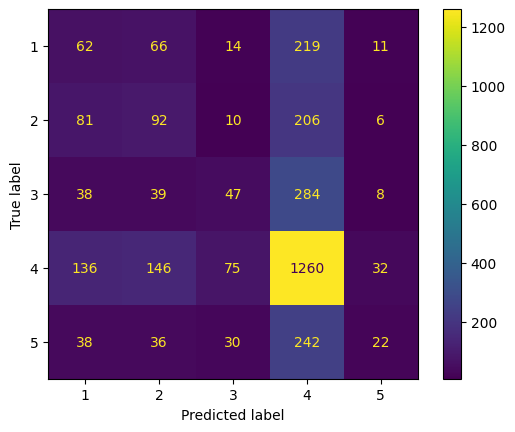

In [76]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_jobs=jobs)
train_and_test_model(knn_model, X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           1       0.20      0.19      0.19       372
           2       0.29      0.57      0.39       395
           3       0.29      0.50      0.37       416
           4       0.72      0.35      0.47      1649
           5       0.17      0.26      0.20       368

    accuracy                           0.37      3200
   macro avg       0.33      0.37      0.32      3200
weighted avg       0.49      0.37      0.38      3200



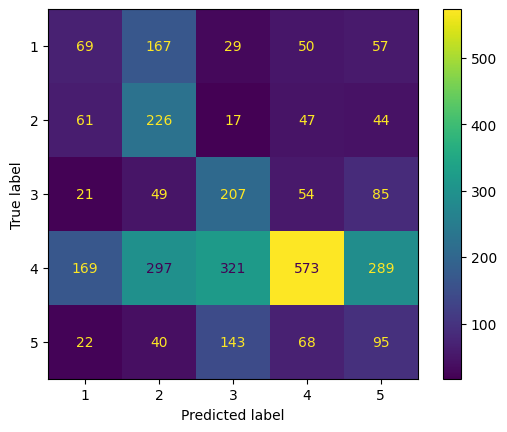

In [77]:
from sklearn.neighbors import NearestCentroid
nearest_centroid_model = NearestCentroid() #n_jobs=jobs)
train_and_test_model(nearest_centroid_model, X_train, X_test, y_train, y_test)

## quadratic discriminant analysis



/home/q/.jupyter/jupyter/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:949: UserWarning: Variables are collinear


              precision    recall  f1-score   support

           1       0.18      0.16      0.17       372
           2       0.28      0.34      0.31       395
           3       0.25      0.25      0.25       416
           4       0.70      0.70      0.70      1649
           5       0.29      0.26      0.27       368

    accuracy                           0.48      3200
   macro avg       0.34      0.34      0.34      3200
weighted avg       0.48      0.48      0.48      3200



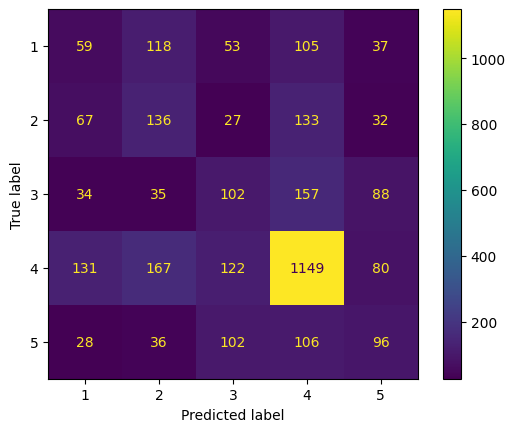

In [78]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda_model = QuadraticDiscriminantAnalysis(store_covariance=True)
train_and_test_model(qda_model, X_train_zero_one, X_test_zero_one, y_train, y_test)

              precision    recall  f1-score   support

           1       0.27      0.02      0.04       372
           2       0.38      0.32      0.35       395
           3       0.43      0.13      0.20       416
           4       0.58      0.92      0.71      1649
           5       0.22      0.05      0.08       368

    accuracy                           0.54      3200
   macro avg       0.37      0.29      0.28      3200
weighted avg       0.46      0.54      0.45      3200



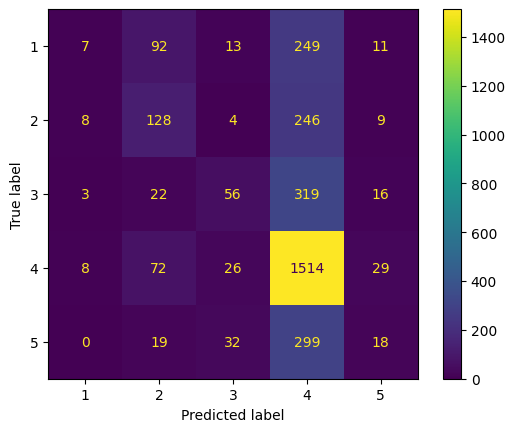

In [79]:
## linear models

from sklearn.linear_model import RidgeClassifier
ridge_model = RidgeClassifier(random_state=42)
train_and_test_model(ridge_model, X_train_zero_one, X_test_zero_one, y_train, y_test)

## naive bayes

try it

              precision    recall  f1-score   support

           1       0.18      0.18      0.18       372
           2       0.23      0.58      0.33       395
           3       0.29      0.47      0.36       416
           4       0.74      0.29      0.41      1649
           5       0.19      0.27      0.22       368

    accuracy                           0.33      3200
   macro avg       0.32      0.36      0.30      3200
weighted avg       0.49      0.33      0.35      3200



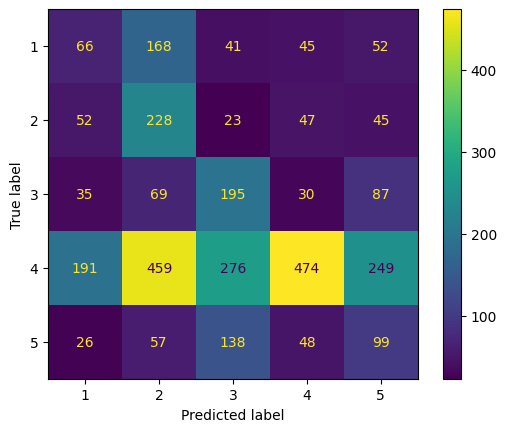

In [80]:
from sklearn.naive_bayes import MultinomialNB
multinomial_nb_model = MultinomialNB(fit_prior=False)
train_and_test_model(multinomial_nb_model, X_train_zero_one, X_test_zero_one, y_train, y_test)

              precision    recall  f1-score   support

           1       0.14      0.05      0.08       372
           2       0.22      0.62      0.32       395
           3       0.29      0.38      0.33       416
           4       0.64      0.46      0.54      1649
           5       0.21      0.11      0.15       368

    accuracy                           0.39      3200
   macro avg       0.30      0.33      0.28      3200
weighted avg       0.44      0.39      0.39      3200



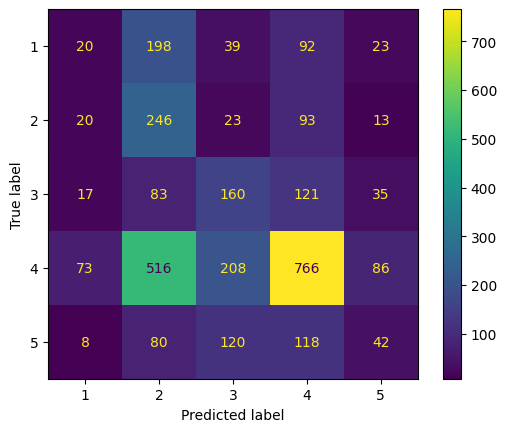

In [81]:
from sklearn.naive_bayes import ComplementNB
multinomial_nb_model = ComplementNB()
train_and_test_model(multinomial_nb_model, X_train_zero_one, X_test_zero_one, y_train, y_test)

## SVM

Use the SGDClassifier with hinge loss to get an parallelized SVM. Input data should be scaled to avoid divergence.

              precision    recall  f1-score   support

           1       0.19      0.24      0.21       372
           2       0.35      0.30      0.32       395
           3       0.38      0.19      0.25       416
           4       0.62      0.79      0.69      1649
           5       0.20      0.06      0.09       368

    accuracy                           0.50      3200
   macro avg       0.35      0.31      0.31      3200
weighted avg       0.46      0.50      0.46      3200



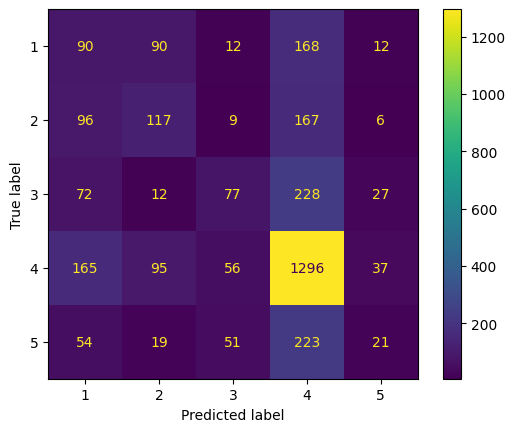

In [82]:
from sklearn.linear_model import SGDClassifier
sgd_model = SGDClassifier(n_jobs=jobs, random_state=42)
train_and_test_model(sgd_model, X_train_normalized, X_test_normalized, y_train, y_test)

Nonparallelized SVC that should scale better to large numbers of samples

              precision    recall  f1-score   support

           1       0.30      0.02      0.04       372
           2       0.39      0.34      0.37       395
           3       0.40      0.16      0.23       416
           4       0.58      0.91      0.71      1649
           5       0.23      0.05      0.08       368

    accuracy                           0.54      3200
   macro avg       0.38      0.30      0.28      3200
weighted avg       0.46      0.54      0.45      3200



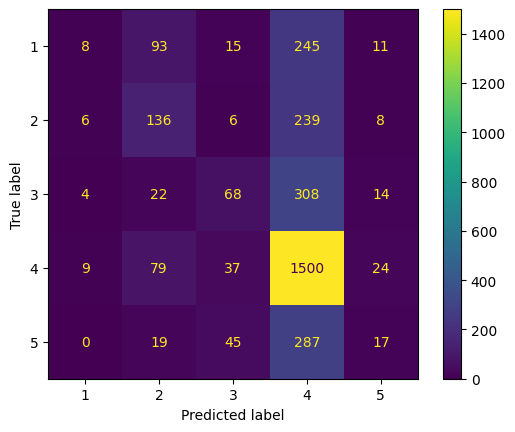

In [83]:
from sklearn.svm import LinearSVC
linear_svc_model = LinearSVC(random_state=42) #, class_weight='balanced') # balanced hurts accuracy
train_and_test_model(linear_svc_model, X_train_normalized, X_test_normalized, y_train, y_test)

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC

# Perform hyperparameter tuning with GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [2, 3, 4],
}

svm_model = SVC(random_state=42)
grid_search = GridSearchCV(svm_model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Best Hyperparameters:", best_params)
print("Accuracy:", accuracy)


from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC

# Perform hyperparameter tuning with RandomizedSearchCV
param_dist = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto', 0.1, 1],
    'kernel': ['linear', 'rbf'],
}

svm_model = SVC(random_state=42)
random_search = RandomizedSearchCV(svm_model, param_distributions=param_dist, n_iter=5, cv=5)
random_search.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params = random_search.best_params_
best_model = random_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Best Hyperparameters:", best_params)
print("Accuracy:", accuracy)

## Random Forest

              precision    recall  f1-score   support

           1       0.43      0.01      0.02       372
           2       0.42      0.19      0.26       395
           3       0.22      0.00      0.01       416
           4       0.54      0.98      0.69      1649
           5       0.00      0.00      0.00       368

    accuracy                           0.53      3200
   macro avg       0.32      0.24      0.20      3200
weighted avg       0.41      0.53      0.39      3200



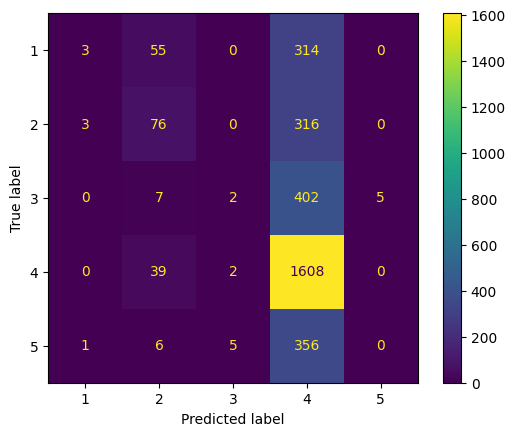

In [84]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42, n_jobs=jobs)#, verbose=1)
train_and_test_model(rf_model, X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           1       0.35      0.02      0.04       372
           2       0.45      0.14      0.21       395
           3       0.50      0.00      0.01       416
           4       0.53      0.98      0.69      1649
           5       0.00      0.00      0.00       368

    accuracy                           0.53      3200
   macro avg       0.37      0.23      0.19      3200
weighted avg       0.43      0.53      0.39      3200



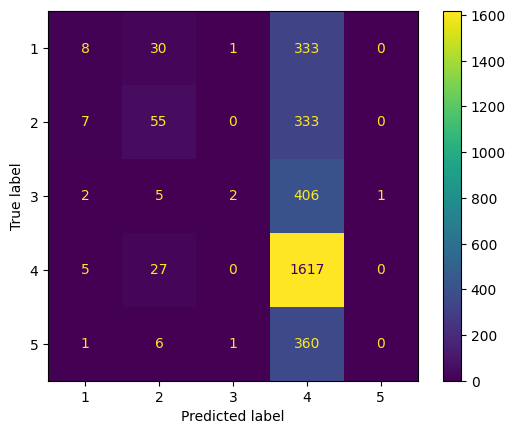

In [85]:
from sklearn.ensemble import ExtraTreesClassifier
extra_trees_model = ExtraTreesClassifier(random_state=42, n_jobs=jobs)#, verbose=1)
train_and_test_model(extra_trees_model, X_train, X_test, y_train, y_test)

from sklearn.ensemble import RandomForestClassifier

def calculate_min_entropy(sequence):
    sequence = np.asarray(sequence, dtype=float)  # Convert sequence to float
    p = np.mean(sequence)  # Proportion of ones
    max_prob = max(p, 1 - p)
    if max_prob == 0:  # Handle the case where all bits are the same
        return 0
    min_entropy = -np.log2(max_prob)
    return min_entropy




vectorized_entropy = np.vectorize(calculate_min_entropy, signature='(n)->()')

# Calculate min-entropy for each sequence in the training and testing datasets
min_entropy_train = vectorized_entropy(X_train)
min_entropy_test = vectorized_entropy(X_test)

X_train_with_entropy = np.column_stack((X_train, min_entropy_train))
X_test_with_entropy = np.column_stack((X_test, min_entropy_test))
# Create the Random Forest classifier
rf_model = RandomForestClassifier(random_state=42)

# Train the model
rf_model.fit(X_train_with_entropy, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test_with_entropy)

# Calculate the accuracy of the Random Forest model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy:", accuracy_rf)


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Create the Random Forest classifier
rf_model = RandomForestClassifier(random_state=42)

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],          # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],         # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],         # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],           # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt'],       # Number of features to consider when looking for the best split
}

# Perform GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(rf_model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions on the test set using the best model
y_pred_rf = best_model.predict(X_test)

# Calculate the accuracy of the Random Forest model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy:", accuracy_rf)
print("Best Hyperparameters:", best_params)


## Gradient Boosting

%%time
from sklearn.ensemble import GradientBoostingClassifier
gb_model = GradientBoostingClassifier(random_state=42)#, verbose=1)
gb_model.fit(X_train, y_train)
y_pred = gb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

A parallelized version is available as Histogram Gradient Boosting model

              precision    recall  f1-score   support

           1       0.24      0.10      0.14       372
           2       0.39      0.26      0.31       395
           3       0.40      0.20      0.27       416
           4       0.63      0.90      0.74      1649
           5       0.33      0.18      0.23       368

    accuracy                           0.55      3200
   macro avg       0.40      0.33      0.34      3200
weighted avg       0.49      0.55      0.50      3200



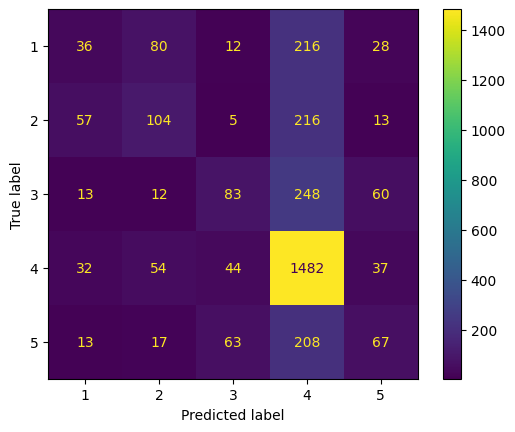

CPU times: user 14.2 s, sys: 354 ms, total: 14.5 s
Wall time: 8.76 s


In [86]:
%%time
from sklearn.ensemble import HistGradientBoostingClassifier
hgb_model = HistGradientBoostingClassifier(random_state=42)#, class_weight='balanced')#, verbose=1)
train_and_test_model(hgb_model, X_train, X_test, y_train, y_test)

from sklearn.ensemble import GradientBoostingClassifier



# Create the Gradient Boosting classifier
gb_model = GradientBoostingClassifier(random_state=42)

# Train the model
# Train the model with the new feature included
gb_model.fit(X_train, y_train)

# Make predictions on the test set with the new feature included
y_pred_gb = gb_model.predict(X_test)

# Calculate the accuracy of the Gradient Boosting model with the new feature
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print("Gradient Boosting Accuracy with Min-Entropy Feature:", accuracy_gb)



GridSearch

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier


def calculate_min_entropy(sequence):
    sequence = np.asarray(sequence, dtype=float)  # Convert sequence to float
    p = np.mean(sequence)  # Proportion of ones
    max_prob = max(p, 1 - p)
    if max_prob == 0:  # Handle the case where all bits are the same
        return 0
    min_entropy = -np.log2(max_prob)
    return min_entropy




vectorized_entropy = np.vectorize(calculate_min_entropy, signature='(n)->()')

# Calculate min-entropy for each sequence in the training and testing datasets
min_entropy_train = vectorized_entropy(X_train)
min_entropy_test = vectorized_entropy(X_test)

X_train_with_entropy = np.column_stack((X_train, min_entropy_train))
X_test_with_entropy = np.column_stack((X_test, min_entropy_test))


# Create the Gradient Boosting classifier
gb_model = GradientBoostingClassifier(random_state=42)

# Define the hyperparameter grid for Grid Search
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
}

# Perform Grid Search with cross-validation (cv=5) to find the best hyperparameters
grid_search = GridSearchCV(gb_model, param_grid, cv=5)
grid_search.fit(X_train_with_entropy, y_train)

# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions on the test set using the best model
y_pred_gb = best_model.predict(X_test_with_entropy)

# Calculate the accuracy of the Gradient Boosting model with the best hyperparameters
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print("Best Hyperparameters:", best_params)
print("Gradient Boosting Accuracy:", accuracy_gb)


Other gradient boosted tree methods may have different runtime/performance

## XGBoost

%%time
from xgboost import XGBClassifier
xgb_model = XGBClassifier(random_state=42, verbosity=1, n_jobs=jobs, tree_method='exact')
y_train_mapped = y_train-1
y_test_mapped = y_test-1
train_and_test_model(xgb_model, X_train, X_test, y_train_mapped, y_test_mapped)

%%time
from xgboost import XGBClassifier
xgb_model = XGBClassifier(random_state=42, verbosity=1, n_jobs=jobs, tree_method='approx')
y_train_mapped = y_train-1
y_test_mapped = y_test-1
train_and_test_model(xgb_model, X_train, X_test, y_train_mapped, y_test_mapped)

              precision    recall  f1-score   support

           0       0.21      0.11      0.14       372
           1       0.41      0.28      0.33       395
           2       0.40      0.21      0.27       416
           3       0.64      0.89      0.75      1649
           4       0.37      0.24      0.29       368

    accuracy                           0.56      3200
   macro avg       0.41      0.35      0.36      3200
weighted avg       0.50      0.56      0.51      3200



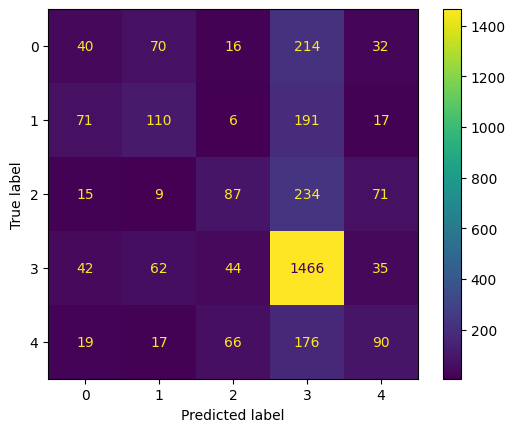

CPU times: user 4.91 s, sys: 207 ms, total: 5.11 s
Wall time: 6.32 s


In [87]:
%%time
from xgboost import XGBClassifier
xgb_model = XGBClassifier(random_state=42, verbosity=1, n_jobs=jobs, tree_method='hist')
y_train_mapped = y_train-1
y_test_mapped = y_test-1
train_and_test_model(xgb_model, X_train, X_test, y_train_mapped, y_test_mapped)

import xgboost as xgb
from sklearn.model_selection import GridSearchCV


# Create the XGBoost classifier
xgb_model = xgb.XGBClassifier(random_state=42)

# Define the hyperparameter grid for Grid Search
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
}

# Map classes to [0, 1, 2]
y_train_mapped = y_train - 1  # This will change classes [1, 2, 3] to [0, 1, 2]

# Continue with the Grid Search
grid_search = GridSearchCV(xgb_model, param_grid, cv=5)
grid_search.fit(X_train, y_train_mapped)

# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_xgb_model = grid_search.best_estimator_

# Make predictions on the test set using the best XGBoost model
y_pred_xgb = best_xgb_model.predict(X_test)

# Calculate the accuracy of the XGBoost model with the best hyperparameters
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("Best Hyperparameters for XGBoost:", best_params)
print("XGBoost Accuracy:", accuracy_xgb)


## CatBoost

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 630
[LightGBM] [Info] Number of data points in the train set: 12800, number of used features: 110
[LightGBM] [Info] Start training from score -2.062093
[LightGBM] [Info] Start training from score -2.076321
[LightGBM] [Info] Start training from score -2.089492
[LightGBM] [Info] Start training from score -0.700833
[LightGBM] [Info] Start training from score -2.059639
              precision    recall  f1-score   support

           1       0.25      0.09      0.13       372
           2       0.42      0.31      0.36       395
           3       0.40      0.16      0.22       416
           4       0.62      0.90      0.73      1649
           5       0.38      0.22      0.28       368

    accuracy                           0.56      32

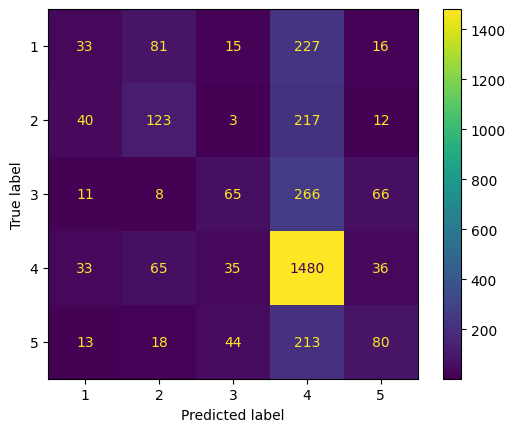

CPU times: user 2.93 s, sys: 136 ms, total: 3.07 s
Wall time: 3.52 s


In [88]:
%%time
import lightgbm as lgb
lgb_model = lgb.LGBMClassifier(random_state=42, n_jobs=jobs, boosting_type='gbdt')
train_and_test_model(lgb_model, X_train, X_test, y_train, y_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 630
[LightGBM] [Info] Number of data points in the train set: 12800, number of used features: 110
[LightGBM] [Info] Start training from score -2.062093
[LightGBM] [Info] Start training from score -2.076321
[LightGBM] [Info] Start training from score -2.089492
[LightGBM] [Info] Start training from score -0.700833
[LightGBM] [Info] Start training from score -2.059639
              precision    recall  f1-score   support

           1       0.28      0.04      0.07       372
           2       0.41      0.24      0.30       395
           3       0.42      0.11      0.17       416
           4       0.57      0.95      0.71      1649
           5       0.36      0.08      0.14       368

    accuracy                           0.54      32

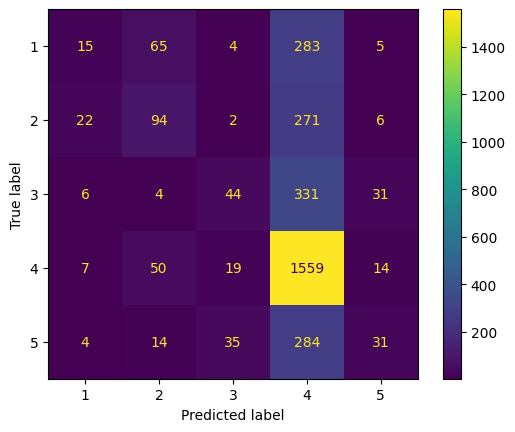

CPU times: user 5.63 s, sys: 140 ms, total: 5.77 s
Wall time: 5.75 s


In [89]:
%%time
import lightgbm as lgb
lgb_model = lgb.LGBMClassifier(random_state=42, n_jobs=jobs, boosting_type='dart')
train_and_test_model(lgb_model, X_train, X_test, y_train, y_test)

# fails
import lightgbm as lgb
lgb_model = lgb.LGBMClassifier(random_state=42, n_jobs=jobs, boosting_type='rf')
lgb_model.fit(X_train, y_train)
y_pred = lgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

import lightgbm as lgb

# Create the LightGBM classifier
lgb_model = lgb.LGBMClassifier(random_state=42)

# Define the hyperparameter grid for Grid Search
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
}

# Perform Grid Search with cross-validation (cv=5) to find the best hyperparameters
grid_search = GridSearchCV(lgb_model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_lgb_model = grid_search.best_estimator_

# Make predictions on the test set using the best LightGBM model
y_pred_lgb = best_lgb_model.predict(X_test)

# Calculate the accuracy of the LightGBM model with the best hyperparameters
accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
print("Best Hyperparameters for LightGBM:", best_params)
print("LightGBM Accuracy:", accuracy_lgb)


## Neural Network

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Neural Network Accuracy: 0.503125
              precision    recall  f1-score   support

           0       0.23      0.11      0.15       372
           1       0.37      0.36      0.36       395
           2       0.32      0.29      0.30       416
           3       0.63      0.75      0.69      1649
           4       0.22      0.19      0.20       368

    accuracy                           0.50      3200
   macro avg       0.36      0.34      0.34      3200
weighted avg       0.47      0.50      0.48      3200



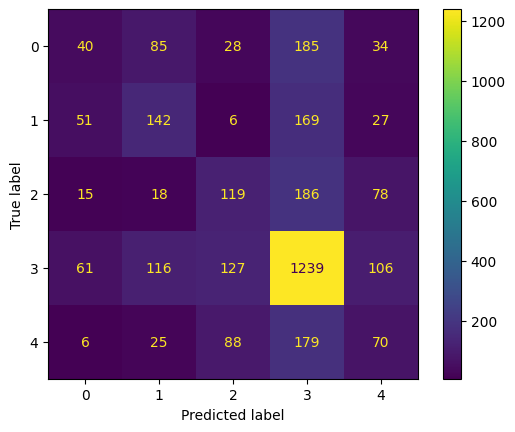

CPU times: user 23.4 s, sys: 2.32 s, total: 25.7 s
Wall time: 27.1 s


In [110]:
%%time
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

keras.utils.set_random_seed(42)

y_train_integer = y_train-1 #.astype('float32')
y_test_integer = y_test-1 #.astype('float32')

X_train_small, X_val, y_train_integer, y_val_integer = train_test_split(X_train, y_train_integer, test_size=0.2, random_state=42)
# print(X_train_small.shape)
# print(X_val.shape)
# print(X_test.shape)
X_train_small = X_train_small.astype('float32')
X_val = X_val.astype('float32')

# Create the Neural Network model
nn_model = Sequential()
nn_model.add(Input(shape=(X_train_small.shape[1],)))
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dense(16, activation='relu'))
nn_model.add(Dense(5, activation='softmax'))

# Compile the model
nn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adamw', metrics=['accuracy'])

# Train the model
nn_model.fit(X_train_small, y_train_integer, epochs=50, batch_size=64, validation_data=(X_val, y_val_integer), verbose=0)

# Make predictions on the test set
y_pred_probabilities = nn_model.predict(X_test.astype('float32'))
y_pred_nn = np.argmax(y_pred_probabilities, axis=-1)

# Calculate the accuracy of the Neural Network model
accuracy_nn = accuracy_score(y_test_integer, y_pred_nn)
print("Neural Network Accuracy:", accuracy_nn)
ConfusionMatrixDisplay.from_predictions(y_test_integer, y_pred_nn)
print(classification_report(y_test_integer, y_pred_nn))
plt.show()
plt.close()

import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# Assuming you have already defined X_train, X_test, y_train, and y_test

# Convert binary numbers to integer labels
label_encoder = LabelEncoder()
y_train_integer = label_encoder.transform(y_train)
y_test_integer = label_encoder.transform(y_test)

# Check unique values in y_train_integer and y_test_integer
print("Unique values in y_train:", np.unique(y_train_integer))
print("Unique values in y_test:", np.unique(y_test_integer))

print("Shape of y_train_integer:", y_train_integer.shape)
print("Shape of y_test_integer:", y_test_integer.shape)

# Manually split the data into training and validation sets
X_train, X_val, y_train_integer, y_val_integer = train_test_split(X_train, y_train_integer, test_size=0.2, random_state=42)

# Create the Neural Network model
nn_model = Sequential()
nn_model.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
nn_model.add(Dense(16, activation='relu'))
nn_model.add(Dense(3, activation='softmax'))

# Compile the model
nn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
nn_model.fit(X_train, y_train_integer, epochs=2, batch_size=64, validation_data=(X_val, y_val_integer), verbose=0)

# Make predictions on the test set
y_pred_probabilities = nn_model.predict(X_test)
y_pred_nn = np.argmax(y_pred_probabilities, axis=-1)

# Calculate the accuracy of the Neural Network model
accuracy_nn = accuracy_score(y_test_integer, y_pred_nn)
print("Neural Network Accuracy:", accuracy_nn)


## LSTM

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
LSTM Accuracy: 0.4509375
              precision    recall  f1-score   support

           0       0.21      0.16      0.18       372
           1       0.27      0.35      0.31       395
           2       0.27      0.39      0.32       416
           3       0.68      0.61      0.64      1649
           4       0.23      0.22      0.23       368

    accuracy                           0.45      3200
   macro avg       0.33      0.35      0.34      3200
weighted avg       0.47      0.45      0.46      3200



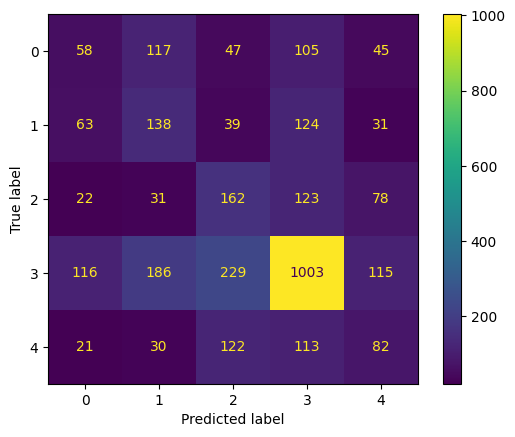

CPU times: user 57.8 s, sys: 3.65 s, total: 1min 1s
Wall time: 44.7 s


In [91]:
%%time
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

keras.utils.set_random_seed(42)

y_train_integer = y_train-1 #.astype('float32')
y_test_integer = y_test-1 #.astype('float32')

X_train_small, X_val, y_train_integer, y_val_integer = train_test_split(X_train, y_train_integer, test_size=0.2, random_state=42)
# print(X_train_small.shape)
# print(X_val.shape)
# print(X_test.shape)
X_train_small = X_train_small.astype('float32')
X_val = X_val.astype('float32')

# Reshape the input data for LSTM
# TODO: LSTM with a single time step is not a sequence!
time_steps = 1  # Each sample is treated as a single time step
X_train_lstm = X_train_small.values.astype('float32').reshape(X_train_small.shape[0], time_steps, X_train_small.shape[1])
X_test_lstm = X_test.values.astype('float32').reshape(X_test.shape[0], time_steps, X_test.shape[1])
X_val_lstm = X_val.values.astype('float32').reshape(X_val.shape[0], time_steps, X_val.shape[1])

# y_train_lstm = y_train_integer.reshape(y_train_integer.shape[0], time_steps, y_train_integer.shape[1])

# Create the Neural Network model
lstm_model = Sequential()
lstm_model.add(Input(shape=(time_steps, X_train_lstm.shape[2])))
lstm_model.add(LSTM(64))
lstm_model.add(Dense(32, activation='relu'))
lstm_model.add(Dense(16, activation='relu'))
lstm_model.add(Dense(5, activation='softmax'))

# Compile the model
lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adamw', metrics=['accuracy'])

# Train the model
lstm_model.fit(X_train_lstm, y_train_integer,
               validation_data=(X_val_lstm, y_val_integer), epochs=50, batch_size=64, verbose=0)

# Make predictions on the test set
y_pred_probabilities = lstm_model.predict(X_test_lstm)
y_pred_lstm = np.argmax(y_pred_probabilities, axis=-1)

# Calculate the accuracy of the LSTM model
accuracy_lstm = accuracy_score(y_test_integer, y_pred_lstm)
print("LSTM Accuracy:", accuracy_lstm)
ConfusionMatrixDisplay.from_predictions(y_test_integer, y_pred_lstm)
print(classification_report(y_test_integer, y_pred_lstm))
plt.show()
plt.close()

import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# ... (Previous code for reading and preprocessing the data)

# Convert the data into numerical format
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

# Reshape the input data for LSTM
time_steps = 1  # Each sample is treated as a single time step
X_train_lstm = X_train.reshape(X_train.shape[0], time_steps, X_train.shape[1])
X_test_lstm = X_test.reshape(X_test.shape[0], time_steps, X_test.shape[1])

# Create the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(32, input_shape=(time_steps, X_train.shape[1])))
lstm_model.add(Dense(16, activation='relu'))
lstm_model.add(Dense(3, activation='sigmoid'))  # Assuming binary classification

# Compile the model
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, verbose=1)

# Make predictions on the test set
y_pred_lstm = lstm_model.predict(X_test_lstm)
y_pred_lstm = np.round(y_pred_lstm).astype(int).flatten()  # Convert probabilities to binary predictions

# Calculate the accuracy of the LSTM model
accuracy_lstm = accuracy_score(y_test, y_pred_lstm)
print("LSTM Accuracy:", accuracy_lstm)
